In [368]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import math
import time
from datetime import timedelta
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import utils

from mae_utils import flat_models
from mae_utils.flat import load_hcp_flat_mask, load_nsd_flat_mask
from mae_utils.flat import create_hcp_flat, create_nsd_flat
import mae_utils.visualize as vis
from mae_utils.losses import SimCLRHandler

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in other files and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

print("\n__CONFIG__")
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

# setup wandb seed
if wandb_log and (wandb_rand==0):
    wandb_rand = str(np.random.randint(99998)+1)
    print("wandb_rand", wandb_rand)
    model_name = model_name + "_" + str(wandb_rand)

# Create outdir for ckpt and config.yaml
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)

# Load previous config.yaml if available
if os.path.exists(f"{outdir}/config.yaml"):
    config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
    print(f"Loaded config.yaml from ckpt folder {outdir}")

    # create global variables from the config
    print("\n__REPLACING_CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    os.environ['TORCH_NCCL_BLOCKING_WAIT'] = '0'
    dist.init_process_group("nccl", timeout=timedelta(seconds=7200000), rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

__CONFIG__
model_name = BOTHflat_large_gsrFalse_newdl
datasets_to_include = NSD
hcp_flat_path = /weka/proj-medarc/shared/HCP-Flat
nsd_flat_path = /weka/proj-medarc/shared/NSD-Flat
model_size = large
global_pool = False
cls_forward = False
gsr = False
use_contrastive_loss = False
use_decoder_contrastive_loss = False
cls_embed = False
decoder_cls_embed = False
use_source_embeds = False
source_embed_mode = add
source_embed_train_mode = ce
patch_size = 16
pct_masks_to_decode = 1
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
contrastive_loss_weight = 1.0
batch_size = 32
num_workers = 1
num_epochs = 100
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
test_num_samples_per_epoch = 

## Create dataset and data loaders

In [369]:
num_batches = num_samples_per_epoch // (num_devices * batch_size)
print("num_batches", num_batches)

print(f"datasets_to_include {datasets_to_include}")
assert datasets_to_include in {"HCP", "NSD", "BOTH"}, "datasets_to_include must be 'HCP', 'NSD', or 'BOTH'"

if "HCP" in datasets_to_include:
    train_dataset = create_hcp_flat(root=hcp_flat_path, 
                    frames=num_frames*2, shuffle=True, 
                    sub_min=sub_min,
                    clip_mode="seq", gsr=gsr) # multiply num_frames by 2 because of TR difference
    train_dl = wds.WebLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    flat_mask = load_hcp_flat_mask()
    nsd_mask = None
    hcp_mask = None
elif "NSD" in datasets_to_include:
    train_dataset = create_nsd_flat(root=nsd_flat_path, num_sessions=num_sessions,
                    frames=num_frames, shuffle=True, gsr=gsr)
    train_dl = wds.WebLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    flat_mask = load_nsd_flat_mask()
    nsd_mask = None
    hcp_mask = None
elif "BOTH" in datasets_to_include:
    nsd_dataset = create_nsd_flat(root=nsd_flat_path, num_sessions=num_sessions,
                frames=num_frames, shuffle=True, gsr=gsr)
    hcp_dataset = create_hcp_flat(root=hcp_flat_path, 
                    frames=num_frames*2, shuffle=True,
                    sub_min=sub_min,
                    clip_mode="seq", gsr=gsr) # multiply num_frames by 2 because of TR difference
    flat_mask = None
    nsd_mask = load_nsd_flat_mask()
    hcp_mask = load_hcp_flat_mask()

    nsd_dl = wds.WebLoader(
        nsd_dataset,
        batch_size=batch_size//2,
        shuffle=False,
        num_workers=num_workers // 2,
        pin_memory=True,
    )
    hcp_dl = wds.WebLoader(
        hcp_dataset,
        batch_size=batch_size//2,
        shuffle=False,
        num_workers=num_workers // 2,
        pin_memory=True,
    )

num_batches 6250
datasets_to_include NSD
Shuffle buffer size: 8428


### Check data loaders work

Yielding 2 batches


  0%|                                                  | 0/6250 [00:00<?, ?it/s]

iter 0


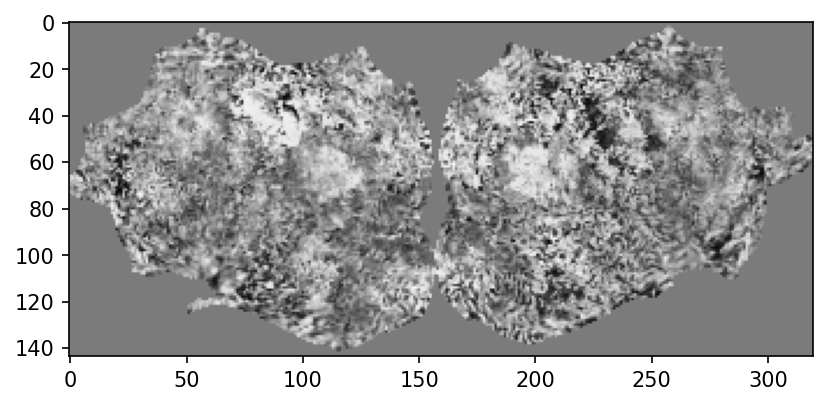

  0%|                                        | 1/6250 [00:03<5:24:44,  3.12s/it]

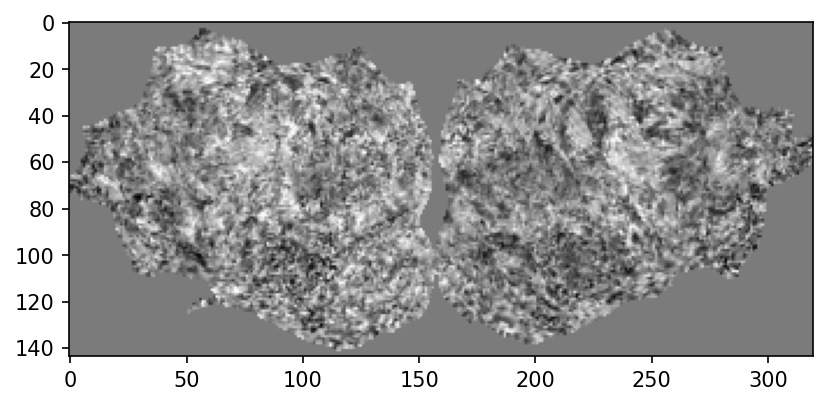

  0%|                                        | 2/6250 [00:05<4:33:25,  2.63s/it]

epochs 2
input_func torch.Size([32, 1, 16, 144, 320])
Execution time: 5.254555940628052 seconds


In [370]:
if utils.is_interactive():    
    start_time = time.time() 
    num_it = 2
    print(f"Yielding {num_it} batches")

    if "BOTH" in datasets_to_include:
        data_iter = zip(hcp_dl, nsd_dl)
    else:
        data_iter = train_dl
    
    for i, batch in enumerate(tqdm(data_iter, total=num_batches)):
        if "BOTH" in datasets_to_include:
            hcp_batch, nsd_batch = batch
            nsd_input = nsd_batch[0]
            hcp_input = hcp_batch[0]

            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = hcp_input.shape
            hcp_input_reshaped = hcp_input.view(len(hcp_input), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            hcp_input = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            
            input_func = torch.cat([hcp_input, nsd_input], dim=0)
        elif "HCP" in datasets_to_include:
            input_func = batch[0]
            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = input_func.shape
            hcp_input_reshaped = input_func.view(len(input_func), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            input_func = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
        else:
            input_func = batch[0]
            
        if len(input_func) != batch_size:
            print("iter", i)
            raise ValueError(f"Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")
            
        if i==0: print("iter",i)
        if i >= num_it:
            break

        plt.imshow(input_func[0,0,0], cmap='gray')
        plt.show()

        # if train_i > num_batches: break

    print("epochs", i)
    print("input_func", input_func.shape)

    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

In [ ]:
# 31.49 no shuffling inside flat.py (num workers 1) 
# 34.79 .shuffle(buffer_size) (num workers 1)
# 33.33 .shuffle(100) (num workers 1)
# 28.73 no shuffling as argument to create_nsd_dataloader (num workers 1) 
# 92.89 no shuffling as argument to create_nsd_dataloader (num workers 8) 
# 44.18 no shuffling as argument to create_nsd_dataloader (num workers 0)
# 81.47 .shuffle(buffer_size) placed after compose() instead of before decode() (num workers 1)
# 16.81 .shuffle(buffer_size) with 4 starts instead of 1 (num workers 1)

# Create model

In [304]:
assert model_size in {"huge", "large", "small"}, "undefined model_size"

if model_size=="huge":
    model = flat_models.mae_vit_huge_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="large":
    model = flat_models.mae_vit_large_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="small":
    model = flat_models.mae_vit_small_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
if use_contrastive_loss:
    model.simclr_handler = SimCLRHandler(model.embed_dim).to(device)
if use_decoder_contrastive_loss:
    model.decoder_simclr_handler = SimCLRHandler(model.decoder_embed_dim).to(device)
utils.count_params(model)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
param counts:
316,392,704 total
316,392,704 trainable


316392704

# Set up optimizer and saving functions

In [305]:
print(f"\nChecking distributed setup on global_rank {global_rank}...")
if distributed:
    from mae_utils.video_vit import Attention
    
    my_auto_wrap_policy = functools.partial(
        transformer_auto_wrap_policy, 
        transformer_layer_cls={Attention,},
    )
    
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    
    # FSDP
    model = FSDP(
        model,
        sharding_strategy=None, # ShardingStrategy.FULL_SHARD, 
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False,
        cpu_offload=None, # CPUOffload(offload_params=True), 
        sync_module_states=True,  # Synchronize module states at the beginning
        limit_all_gathers=True,  # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
        mixed_precision=MixedPrecision(param_dtype=torch.float32, reduce_dtype=torch.float32, buffer_dtype=torch.float32),
    )
    
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [306]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.001 by effective batch size 32
lr = 0.000125

Done with model preparations!
param counts:
316,392,704 total
316,392,704 trainable


In [307]:
def save_ckpt(model,tag="last"):
    if distributed: dist.barrier()
    model_states = model.state_dict()
    optimizer_states = optimizer.state_dict()
    if global_rank == 0:
        os.makedirs(outdir,exist_ok=True)
        ckpt_path = outdir+f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer_states,
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")
        
        # save the config.yaml
        if not os.path.exists(f"{outdir}/config.yaml"):
            with open(f"{outdir}/config.yaml", 'w') as file:
                yaml.dump(config, file)
            print(f"saved {outdir}/config.yaml!")

# Load checkpoint

In [308]:
epoch = 0
outdir_to_load = outdir #'/weka/proj-fmri/paulscotti/fMRI-foundation-model/src/checkpoints/HCPflat_large_gsrFalse_'
if resume_from_ckpt and local_rank==0:
    if not os.path.exists(outdir_to_load) or not os.path.isdir(outdir_to_load):
        print(f"\nNot resuming from ckpt. Checkpoint folder {outdir_to_load} does not exist.\n")
    else:
        checkpoint_files = [f for f in os.listdir(outdir_to_load) if f.endswith('.pth')]

        # Extract epoch numbers and find the largest
        epoch_numbers = []
        for file in checkpoint_files:
            try:
                epoch_number = int(file.split('epoch')[-1].split('.')[0])
                epoch_numbers.append(epoch_number)
            except ValueError:
                continue

        latest_epoch = max(epoch_numbers)
        latest_checkpoint = f"epoch{latest_epoch}.pth"

        # Load the checkpoint
        checkpoint_path = os.path.join(outdir_to_load, latest_checkpoint)

        state = torch.load(checkpoint_path)
        model.load_state_dict(state["model_state_dict"], strict=True)
        # epoch = state['epoch'] + 1
        
        # Optimizer loading
        saved_state_dict = state['optimizer_state_dict']
        # adjust the saved state dict to match the current optimizer's structure
        for i, group in enumerate(optimizer.param_groups):
            # Ensure the params in the saved state match the current optimizer's params
            saved_state_dict['param_groups'][i]['params'] = group['params']
        optimizer.load_state_dict(saved_state_dict)

        print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir_to_load}. Epoch = {epoch}\n")


Not resuming from ckpt. Checkpoint folder /weka/proj-fmri/paulscotti/fMRI-foundation-model/src/checkpoints/NSDflat_large_gsrFalse_31627_28111 does not exist.



# Start wandb (if enabled)

In [309]:
if utils.is_interactive():
    print("Running inside interactive notebook. Disabling wandb and ckpt saving...")
    wandb_log = False
    ckpt_saving = False
if global_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'fMRI-foundation-model'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "norm_pix_loss": norm_pix_loss,
      "patch_size": patch_size,
      "t_patch_size": t_patch_size,
      "pred_t_dim": pred_t_dim,
      "mask_ratio": mask_ratio,
      "num_frames": num_frames,
      "sep_pos_embed": sep_pos_embed,
      "decoder_embed_dim": decoder_embed_dim,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "num_sessions": num_sessions,
      "base_lr": base_lr,
      "lr": lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "test_num_samples_per_epoch": test_num_samples_per_epoch,
      "test_set": test_set,
      "grad_clip": grad_clip,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "grad_accumulation_steps": grad_accumulation_steps,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
        save_code=True,
    )
    
    # Reprint the config so that wandb captures it in the output log
    print("\n__CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")
else:
    wandb_log = False

Running inside interactive notebook. Disabling wandb and ckpt saving...


# Start training

In [310]:
lrs, train_losses, test_losses = [], [], []
recon_losses1, source_losses1, recon_losses2, source_losses2 = [], [], [], []
encoder_cont_losses, decoder_cont_losses = [], []

In [311]:
grad_scaler = torch.amp.GradScaler(enabled=True)
progress_bar = tqdm(range(epoch, num_epochs), disable=global_rank!=0, desc="Overall")
if distributed: dist.barrier()
for epoch in progress_bar:
    model.train()
    if "BOTH" in datasets_to_include:
        data_iter = zip(hcp_dl, nsd_dl)
    else:
        data_iter = train_dl
    
    for train_i, batch in enumerate(data_iter):
        if "BOTH" in datasets_to_include:
            hcp_batch, nsd_batch = batch
            nsd_input = nsd_batch[0].to(device=device, non_blocking=True)
            hcp_input = hcp_batch[0].to(device=device, non_blocking=True)

            if train_i==0:
                print(f"global_rank{global_rank} len(nsd_input){len(nsd_input)} len(hcp_input){len(hcp_input)}")

            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = hcp_input.shape
            hcp_input_reshaped = hcp_input.view(len(hcp_input), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            hcp_input = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            
            input_func = torch.cat([hcp_input, nsd_input], dim=0)
            
            if len(input_func) != batch_size:
                raise ValueError(f"Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")
                
            if use_source_embeds:
                hcp_source_ids = torch.LongTensor([1 if np.array(meta)=='3T' else 2 for meta in hcp_batch[1]["mag"]])
                nsd_source_ids = torch.LongTensor([0 for _ in range(len(nsd_batch[0]))])
                source_ids = torch.cat([hcp_source_ids, nsd_source_ids], dim=0).to(device=device, non_blocking=True)
            else:
                source_ids = None
        else:
            input_func = batch[0].to(device=device, non_blocking=True)
            
            if len(input_func) != batch_size:
                raise ValueError(f"Error! Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")

            if "HCP" in datasets_to_include:
                # average pooling across consecutive frames to have approx similar TR across datasets
                hcp_shape = input_func.shape
                hcp_input_reshaped = input_func.view(len(input_func), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
                input_func = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            
            if use_source_embeds:
                if "HCP" in datasets_to_include:
                    source_ids = torch.LongTensor([1 if np.array(meta)=='3T' else 2 for meta in batch[1]["mag"]])
                else:
                    source_ids = torch.LongTensor([0 for _ in range(len(batch[0]))])
                source_ids = source_ids.to(device=device, non_blocking=True)
            else:
                source_ids = None

        adjust_learning_rate(optimizer, train_i / num_batches + epoch)

        if not use_contrastive_loss:
            loss, source_loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss, source_ids=source_ids)
            loss = loss + source_loss
        else:
            recon_loss1, source_loss1, recon_loss2, source_loss2, encoder_cont_loss, decoder_cont_loss, pred1, pred2, mask1, mask2, true_mask, latent1, latent2 = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss, source_ids=source_ids, distributed=distributed)
            pred, mask = pred1, mask1

            loss = recon_loss1 + source_loss1 + recon_loss2 + source_loss2 + encoder_cont_loss + decoder_cont_loss
            
            recon_losses1.append(recon_loss1.item())
            source_losses1.append(source_loss1.item())
            recon_losses2.append(recon_loss2.item())
            source_losses2.append(source_loss2.item())
            encoder_cont_losses.append(encoder_cont_loss.item())
            decoder_cont_losses.append(decoder_cont_loss.item())

        loss = loss / grad_accumulation_steps # normalize the loss by grad accumulation steps
        grad_scaler.scale(loss).backward()
        
        if (train_i + 1) % grad_accumulation_steps == 0:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            optimizer.zero_grad()
            torch.cuda.synchronize()

        lrs.append(optimizer.param_groups[0]["lr"])
        train_losses.append(loss.item() * grad_accumulation_steps)
        
        if ((train_i%print_interval)==0 or (train_i==num_batches-1)) and train_i>0:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            if wandb_log: 
                if not use_contrastive_loss:
                    logs = {"train/loss": np.mean(train_losses[-print_interval:])}
                else:
                    logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                            "train/recon_loss": np.mean(recon_losses1[-print_interval:] + recon_losses2[-print_interval:])/2,
                            "train/source_loss": np.mean(source_losses1[-print_interval:] + source_losses2[-print_interval:])/2,
                            "train/cont_loss": np.mean(encoder_cont_losses[-print_interval:]),
                           }
                    if use_decoder_contrastive_loss:
                        logs["train/decoder_cont_loss"] = np.mean(decoder_cont_losses[-print_interval:])
                # epoch_1000x as x-axis calibrates different curves when batch size changes
                epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                wandb.log(logs, step=epoch_1000x)

        if train_i > num_batches:
            break
                
    print(f"\nPassed training epoch {epoch}")

    ### TODO: Add eval for held-out test set ###
                
    if utils.is_interactive() or wandb_log:
        print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
        if plotting:
            with torch.no_grad():
                print("\n Train plotting...")
                if norm_pix_loss:
                    normed_input_func, patch_info = model.patchify(input_func, alter_patch_info=False, return_patch_info=True)
                    target_mean = normed_input_func.mean(dim=-1, keepdim=True)
                    target_var = normed_input_func.var(dim=-1, keepdim=True)
                    normed_input_func = (normed_input_func - target_mean) / (target_var + 1.0e-6) ** 0.5
                    normed_input_func = model.unpatchify(normed_input_func, patch_info=patch_info)
    
                    vis_out = vis.plot_mask_pred(
                        model, normed_input_func, pred, mask, 
                        mean=0.5, std=0.2, 
                    )
                else:
                    vis_out = vis.plot_mask_pred(
                        model, input_func, pred, mask, 
                        mean=0.5, std=0.2, 
                    )
    
                if wandb_log:
                    logs = {"train/mask_pred": wandb.Image(vis_out)}
                    epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                    wandb.log(logs, step=epoch_1000x)
                else:
                    display(vis_out)

    # Save model checkpoint
    if ckpt_saving and epoch>0 and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
        save_ckpt(model,f"epoch{epoch}")

    # wait for other GPUs to catch up if needed
    if distributed: 
        print(f"global_rank{global_rank} hit barrier...")
        dist.barrier()
    
    # close any open plots
    if plotting:
        plt.close()
    
if distributed: dist.destroy_process_group()

Overall:   0%|                                          | 0/100 [00:00<?, ?it/s]

Ep. 0 | loss 2.103 | lr 8e-08 | 20/6250


Overall:   0%|                                          | 0/100 [05:09<?, ?it/s]


KeyboardInterrupt: 

Exception in thread Thread-84 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 55, in _pin_memory_loop
    do_one_step()
  File "/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 32, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi